<h3>Imports and global assignments<h3>

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
NUM_OF_DATA_FIELDS = 6
BINARY_FIELDS = []
TERNARY_FIELDS = [(1,2), (3,4,5)]



In [2]:
import torch
from torch.nn.functional import softmax, normalize
from torch import nn, cuda, mm
import random as r

<h3>Functions for making state graphs<h3>

In [3]:
def make_grid_state(n_dist, x, y):
    graph = nx.grid_graph((x,y))
    n_prec = x * y
    precinct_numbers = assign_total_between_buckets(n_dist, n_prec)
    actual_proportions = generate_sensical_proportions()
    all_districts = generate_graph(graph, precinct_numbers, actual_proportions)
    return all_districts, actual_proportions

In [4]:
def assign_total_between_buckets(buckets, total):
    bucket_totals = []
    for i in range(buckets):
        if i == buckets - 1:
            bucket_totals.append(total)
        else:
            portion = np.random.randint(1, high = total - (buckets - i - 1)) #choose a random fraction
            bucket_totals.append(portion)
            total -= portion
    np.random.shuffle(bucket_totals)
    return bucket_totals

In [5]:
def generate_sensical_proportions():
    result = np.random.random(NUM_OF_DATA_FIELDS) #the binary fields can just have random proportions in them
    result[0] = 1 #the proportion of people who live in the state to people who live in the state is simply 1
    for group_of_categories in TERNARY_FIELDS:
        #distribute the total population between the categories plus an extra
        cat_proportions = assign_percent_between_buckets(len(group_of_categories), 1) 
        result[np.array(group_of_categories)] = cat_proportions #exclude the last number because it is implied
    return result

#Method to randomly distribute a percentage between some number of buckets (use start = 1 if distributing a whole)
#otherwise, start should be between 0 and 1
def assign_percent_between_buckets(buckets, start):
    bucket_fractions = []
    total = start
    for i in range(buckets):
        if i == buckets - 1:
            bucket_fractions.append(total)
        else:
            portion = random.uniform(0, total) #choose a random fraction of number
            #without taking too much for the next district
            bucket_fractions.append(portion)
            total -= portion
    np.random.shuffle(bucket_fractions)
    return bucket_fractions

In [32]:
def generate_graph(graph, precinct_numbers, actual_proportions):
    n_dist = len(precinct_numbers)
  #Start by creating a data matrix: one row per district
    data_matrix = np.empty((n_dist, NUM_OF_DATA_FIELDS))
  #fill in the population data evenly
    data_matrix[:,0] = assign_population_evenly(n_dist, 1, 0.1)
    if len(BINARY_FIELDS) > 0: #Just a precaution
        print("UNIMPLEMENTED SEGMENT OF CODE! PLEASE FIX")
        exit(0)
    for list_of_categories in TERNARY_FIELDS:
        limits = data_matrix[:,0] #start with the limit being the proportion of the population occupied by the district
        totals = actual_proportions[np.array(list_of_categories)]
        mini_matrix = assign_across_categories(totals,limits)
        for i in range(len(list_of_categories)):
            index = list_of_categories[i]
            data_matrix[:,index] = mini_matrix[:,i]
    #print(data_matrix)
    node_list = [node for node in graph.nodes()]
    for i in range(n_dist):
        district_matrix = gen_district_matrix(precinct_numbers[i], data_matrix[i,:]) #generate the district data matrix,
    # feeding in the number of precincts and the proportions that must be split between the precincts
        for j in range(precinct_numbers[i]):
            graph.nodes[node_list[0]]['label'] = i
            graph.nodes[node_list[0]]['features'] = district_matrix[j,:]
            node_list.pop(0)
    return graph

def assign_across_categories(totals, limits):
    result = np.random.random((limits.shape[0], totals.shape[0]))
  # old_result = np.zeros((limits.shape[0], totals.shape[0]))
  # while not (result == old_result).all():
  #   old_result = result
    for i in range(100):
        result /= result.sum(0)
        result *= totals
        result /= result.sum(1).reshape(limits.shape[0],1)
        result *= limits.reshape(limits.shape[0],1)
    return result

#Method to randomly distribute a population, in terms of fractions that all sum to 1,
#more or less evenly (within 1 percentage point of the ideal)
#Param: int buckets: number of districts
def assign_population_evenly(buckets, total, allowed_variation):
    bucket_fractions = []
    base_max_pop = (1 + allowed_variation) / buckets
    base_min_pop = (1 - allowed_variation) / buckets
    max_pop = base_max_pop
    min_pop = base_min_pop
    avg = (max_pop + min_pop) / 2
    total_variation = 0 #this will be negative if the average is tending high and positive if it is tending low
    for i in range(buckets):
        if i == buckets - 1:
            bucket_fractions.append(total)
        else:
            portion = random.uniform(min_pop, max_pop) #choose a random fraction of 1 without straying out of range
            bucket_fractions.append(portion)
            total -= portion
            total_variation += (portion - avg) #if portion is lower than average,
            #this lowers total variation; otherwise, it raises it
            if total_variation > 0: #if we're erring a little too high
                min_pop = base_min_pop
                max_pop = avg
            else: #erring a little too low
                min_pop = avg
                max_pop = base_max_pop
    np.random.shuffle(bucket_fractions)
    return bucket_fractions

In [33]:
#Method to generate a planar graph (one that could be converted to an actual map)
#containing a specified number of nodes (regions/precincts)
def gen_district_matrix(nodes, attributes_to_split):
  #Populate the nodes with data; for simplicity and ease of modification we will use only one field
  #with an array containing all the attributes
  #start by creating a data matrix with one row for every node
    node_matrix = np.empty((nodes, NUM_OF_DATA_FIELDS))
  # for i in range(NUM_OF_DATA_FIELDS): #distribute portions of allotted numbers among the rows
  #   node_matrix[:,i] = assign_percent_between_buckets(nodes, attributes_to_split[i])
    node_matrix[:,0] = assign_percent_between_buckets(nodes, attributes_to_split[0])
    if len(BINARY_FIELDS) > 0: 
        print("UNIMPLEMENTED SEGMENT OF CODE! PLEASE FIX")
        exit(0)
    for list_of_categories in TERNARY_FIELDS:
        limits = node_matrix[:,0] #start with the limit being the proportion of the population occupied by the district
        totals = attributes_to_split[np.array(list_of_categories)]
        mini_matrix = assign_across_categories(totals,limits)
        for i in range(len(list_of_categories)):
            index = list_of_categories[i]
            node_matrix[:,index] = mini_matrix[:,i]
    return node_matrix

In [39]:
# Makes a partitioned grid graph in which the partisan split is fairly even
def make_fairish_state():
    state, proportions = make_grid_state(10, 10, 10)
    competitiveness = get_competitiveness(state, proportions)
    while not(.35 < competitiveness < 2.87):
        state, proportions = make_grid_state(10, 10, 10)
        competitiveness = get_competitiveness(state, proportions)
    return state, proportions

In [40]:
# Helper function to figure out the partisan split in a state
def get_competitiveness(state, proportions):
    party1, party2 = tuple(majority_outcomes(state, proportions))
    if party1 == 0 or party2 == 0:
        competitiveness = np.inf
    else:
        competitiveness = party1/party2 
    return competitiveness

<h3>Functions for evaluating partitioned state graphs<h3>

In [34]:
#Calculate an evaluation of how much the state has been gerrymandered per feature in the feature array
#The feature array looks like: 0: pop, 1: party 1 (binary), 2: minority (binary), 3: age 1 (trinary), 4: age 2 (trinary), 5: income bracket 1 (binary)
#(see "Notes on node data" for more notes on the attributes)
#Param: nx.Graph graph: the graph of the state, with districts apportioned by the "label" attribute
#Param: int[] total_proportions: should look like [1, % of state belonging to party 1, % of state in a racial minority, etc.]
#these are the "target values" that a fair districting plan would try to approximate and that a gerrymander would stray from
#Returns: a list of values indicating the "approximation" proportions (the ones created by majorities in districts)
def majority_outcomes(graph, total_proportions):

    districts = get_district_subgraphs(graph)
    all_district_proportions = np.empty((len(districts),NUM_OF_DATA_FIELDS)) #one row per district, one column per attribute

  #start by calculating the values for the different attributes
    for i in range(len(districts)):
        all_district_proportions[i,:] = district_proportions(districts[i]) #one row per district
  
  #evaluate how many districts the binary attributes have a majority in
    binary_majority_count = np.zeros(2)
    for binary_item in [(1,2)]:
        for proportion in all_district_proportions[:, binary_item]:
            #print((proportion[0] * total_proportions[1],proportion[1] * total_proportions[2]))
            if proportion[0] * total_proportions[1] > proportion[1] * total_proportions[2]:
                binary_majority_count[0] += 1
            elif proportion[1] * total_proportions[2] > proportion[0] * total_proportions[1]:
                binary_majority_count[1] += 1
    #print(binary_majority_count)
  #evaluate ternary attributes
    #ternary_plurality_count = np.zeros(NUM_OF_DATA_FIELDS)
    #for ternary_items in TERNARY_FIELDS: #fields are tuples
    #    for i in range(len(districts)):
      #make an array to store the proportions in the district
    #        to_compare = np.zeros(len(ternary_items)) #the strange syntax here is so that this can be adapted to other category sizes
      #get proportions for different items
    #        for j in range(len(ternary_items)):
    #            to_compare[j] = all_district_proportions[i, ternary_items[j]]
    #        plurality_index = np.argmax(to_compare)
    #        ternary_plurality_count[ternary_items[plurality_index]] += 1
    #print(all_district_proportions)
    #print(ternary_plurality_count)
    #total_plurality_count = binary_majority_count + ternary_plurality_count
    #total_plurality_count /= len(districts) #get proportion of districts in which the category wins
    #return total_plurality_count #see how well the proportions of wins in the districts approximated the actual proportions!
    return binary_majority_count/len(districts)

In [35]:
#return a list of subgraphs, split by the labels assigned to the nodes
def get_district_subgraphs(graph):
    subgraphs = []
    subgraph_nodes = {}
  #create a dictionary of nodes that belong in the different subgraphs
    for node in graph.nodes:
        label = graph.nodes[node]['label']
        if label in subgraph_nodes:
            subgraph_nodes[label].append(node)
        else:
            subgraph_nodes[label] = [node]
  #get a list of subgraphs
    for label in subgraph_nodes:
        subgraph = graph.subgraph(subgraph_nodes[label]).copy()
        subgraphs.append(subgraph)
    return subgraphs

In [36]:
def district_proportions(district):
    district_proportions = np.zeros(NUM_OF_DATA_FIELDS)
    for node in district.nodes:
        for i in range(NUM_OF_DATA_FIELDS):
            district_proportions[i] += district.nodes[node]['features'][i]
  #Now that we have total proportions, we can multiply those with state proportions and population proportions to get an overall proportion
  # print(district_proportions)
  # result = (1 / district_proportions[0]) * total_proportions
  # result = result * district_proportions
    return district_proportions

<h3>Code for gerrymandering partitioned graph<h3>

In [62]:
"""
    A class for gerrymandering graph representations of states

    Attributes
    ----------
    Assignment : nxk tensor
        the initial district assignments of nodes in the graph
    Partisanship : nx2 tensor
        the partisan breakdown in each node as a proportion of the total state partisanship
        one of the columns must be all positive numbers, the other must be all negatives
        the class will optimize assignments in favor of the negative column
    StateData : 2x1 tensor
        the statewide partisan breakdown
    
    Methods
    -------
    train(n)
        Runs training loop for n iterations
    get_assignment()
        Returns the learned assignment matrix
    """
class Gerrymanderer(torch.nn.Module):
    def __init__(self, Assignment, Partisanship, StateData, Adjacency, lr=.005):
        super().__init__()
        self.register_parameter(name='Assignment', param=torch.nn.Parameter(torch.clone(Assignment).cuda()))
        self.Partisanship = torch.clone(Partisanship).cuda()
        self.StateData = torch.clone(StateData).cuda()
        self.Adjacency = torch.clone(Adjacency).cuda()
        self.initial_assignment = Assignment.cuda()
        self.xero, self.yero = torch.where(torch.mm(self.Adjacency, self.Assignment)<0.01)
        #self.xero = torch.where(torch.mm(self.Adjacency, self.Assignment)<0.01)[0].cuda()
        #self.yero = torch.where(torch.mm(self.Adjacency, self.Assignment)<0.01)[1].cuda()
        self.optim = torch.optim.RAdam(self.parameters(), lr)

    def forward(self):
        return torch.special.erf(torch.mul(mm(mm(softmax(torch.mul(self.Assignment, 10), dim=1).T, self.Partisanship), self.StateData).T, 10))
  
    def loss(self, predicted):
        return torch.sum(predicted)
  
    def freeze_gradients(self):
        with torch.no_grad():
            # if a cluster just has one node, freeze the gradient of that node so the district isn't eliminated
            for i, district in enumerate(softmax(torch.mul(self.Assignment, 10), dim=1).T):
                    if torch.sum(district) < .9:
                        self.Assignment.grad[torch.argmax(district), i] = 0
            # if removing a node from a cluster would break contiguity, freeze that node

            # freeze gradients where a node is not adjacent to a cluster
            to_freeze = list(zip(self.xero, self.yero))
            for i, j in to_freeze:
                self.Assignment.grad[i,j] = 0
  
    def train(self, n):
        for i in range(n):
            self.optim.zero_grad()
            prediction = self.forward()
            error = self.loss(prediction)
            error.backward()
            self.freeze_gradients()
            self.optim.step()
            #print(error)

    def get_assignment(self):
        new_assignments = torch.clone(self.Assignment)
        for i, row in enumerate(new_assignments):
            new_assignments[i] = torch.where( torch.logical_and(row==torch.max(new_assignments[i]), torch.gt(torch.max(new_assignments[i]), 0)), 1., 0.)
            if not torch.any(new_assignments[i] > 0):
                new_assignments[i] = self.initial_assignment[i]
        return new_assignments

In [38]:
# Gets appropriate format out of nx graph
def clean_input_graph(G, proportions):
    Partisanship = torch.tensor(np.array(list(nx.get_node_attributes(G, 'features').values()))[:,1:3]).float()
    Partisanship[:,1] = torch.mul(Partisanship[:,1], -1)
    #print(Partisanship)
    StateData = torch.tensor(proportions[1:3]).reshape((2,1)).float()
    Adjacency = torch.tensor(nx.adjacency_matrix(G).todense()).float()
    clusters =  list(nx.get_node_attributes(G, 'label').values())
    cluster_names = np.unique(clusters)
    Assignment = np.zeros((len(clusters), len(cluster_names)))
    for i, c in enumerate(clusters):
        for j, name in enumerate(cluster_names):
            if c == name:
                Assignment[i, j] = 1
    Assignment = torch.tensor(Assignment).float()
    #print(Adjacency.shape[0])
    for i in range(Adjacency.shape[0]):
        Adjacency[i,i] = 1
    return Assignment, Partisanship, StateData, Adjacency


In [76]:
# Generates gerrymandered graphs from fairish states
def gerry_func():
    state, proportions = make_fairish_state()
    Assignment, Partisanship, StateData, Adjacency = clean_input_graph(state, proportions)
    g = Gerrymanderer(Assignment, Partisanship, StateData, Adjacency).cuda()
    g.train(1000)
    while not bool(torch.any(g.get_assignment().cpu()!=Assignment)):
        g.train(1000)
        if torch.std(g.get_assignment().cpu()) == 0:
            print('failed')
            break
    #print(majority_outcomes(state, proportions))
    #print(majority_outcomes(assignment_matrix_to_new_assignments(state, g.get_assignment()), proportions))
    return assignment_matrix_to_new_assignments(state, g.get_assignment()), proportions

In [66]:
# Converts from assignment matrix to nx graph
def assignment_matrix_to_new_assignments(old_graph, assignments):
    assignments = assignments.detach().cpu().numpy()
    new_graph = old_graph.copy()
    node_list = [node for node in old_graph.nodes()]
    for i, node in enumerate(new_graph.nodes):
        assignment = np.nonzero(assignments[i,:])
        #print(i)
        new_graph.nodes()[node]['label'] = int(assignment[0])
    return new_graph

<h3>Classes for loading in and representing data<h3>

In [120]:
"""
    A class for learning hypothesis from unpartitioned precinct data to chosen clusters

    Attributes
    ----------
    gr : tuple(A, X)
        the unpartioned map graph
        A : nxn tensor
          the adjacency matrix of gr
        X : nxd tensor
          the feature matrix of gr
    y : nxk tensor
        the assignment matrix of the actual clustering, eg:
        [[0, 0, 1]
         [1, 0, 0]
         [0, 0, 1]
         [0, 0, 1]
         [0, 1, 0]
         [0, 1, 0]
         [1, 0, 0]
         [0, 1, 0]]
    lr (default=.009) : float
        the learning rate
    

    Methods
    -------
    train(n)
        Runs training loop for n iterations
    featurewise_hypothesis()
        Returns d length vector representation of hypothesis for classification
    """
class Partitioner(torch.nn.Module):
    def __init__(self, gr, y, lr=.001, hypothesis=None):
        super().__init__()
        self.A, self.X = gr
        self.y = y
        self.lr = lr
        # local minimum closest to origin tends to be steepest, so initialize hypothesis to zeros
      
        #self.row_optims = []
        if hypothesis is None:
            self.register_parameter(name='hypothesis', param=torch.nn.Parameter(torch.zeros(len(self.X.T),len(self.y.T))))
        else:
            self.register_parameter(name='hypothesis', param=hypothesis)
        self.optim = torch.optim.RAdam(self.parameters(), lr)

    def forward(self):
        return softmax(mm(mm(self.A, self.X), self.hypothesis), dim=1)

    def h_loss(self, predicted, actual):
        return torch.sum(torch.square(torch.sub(predicted, actual)))
    
    def train(self, n):
        for i in range(n):
            self.optim.zero_grad()
            prediction = self.forward()
            error = self.h_loss(prediction, self.y)
            #print(error)
            error.backward()
            self.optim.step()
            #print(error)

    def featurewise_hypothesis(self):
        #print(self.hypothesis)
        # returns standard deviation of each feature (row) so that classification architecture doesn't have to restrict number of clusters
        # average absolute value will tend upward with each training iteration, so divide by max to normalize
        return torch.std(torch.div(self.hypothesis, torch.max(self.hypothesis)), dim=1) 

In [108]:
"""
    A class for loading and data, as well as storing and training hyptheses of said data
    
    Attributes
    ----------
    control_func : function
        should generate non-gerrymandered state maps in the form of an nx graph

    Methods
    -------
    load(c_n, g_n)
        Loads c_n control graphs and g_n gerrymandered graphs
    
    featurewise_representations()
        Learns and returns the list of learned hypotheses from the unpartioned graphs to the chosen clusters
    
    dataset()
        Returns a list of hypotheses and their labels for classification
    
    save()
        Saves data and labels as tensors in respective files
    
    load_file()
        Loads data and labels from files
    """
class data_loader():
    def __init__(self, control_func, gerry_func):
        self.labels = []
        self.data = []
        self.featurewise = []
        self.control_func = control_func
        self.gerry_func = gerry_func
        self.proportions = []
        self.outcomes = []

    # funcs return graph with labels stored in nodes
    def load_(self, n, gerry):
        if gerry: func = self.gerry_func
        else: func  = self.control_func
        for i in range(n):
            assignments = []
            raw, proportions = func()
            self.proportions.append(proportions[1:3])
            self.outcomes.append(tuple(majority_outcomes(raw, proportions)))
            A = nx.adjacency_matrix(raw).todense()
            X = np.array(list(nx.get_node_attributes(raw, 'features').values()))
            clusters =  list(nx.get_node_attributes(raw, 'label').values())
            cluster_names = np.unique(clusters)
            assignment_matrix = np.zeros((len(clusters), len(cluster_names)))
            for i, c in enumerate(clusters):
                for j, name in enumerate(cluster_names):
                    if c == name:
                        assignment_matrix[i, j] = 1
            self.data.append(((A, X), assignment_matrix))
            if gerry:
              self.labels.append(1.)
            else:
              self.labels.append(0.)

    def load(self, c_n, g_n):
        self.load_(c_n, False)
        self.load_(g_n, True)
    
    def save(self):
        torch.save(torch.tensor(self.data), 'data.pt')
        torch.save(torch.tensor(self.labels), 'labels.pt')

    def load_file(self):
        self.data = torch.load('data.pt').tolist()
        self.labels = torch.load('labels.pt').tolist()

    def featurewise_representations(self, party_limited=False, generate=True):
        if generate:
            self.featurewise = []
            for datum in self.data:
                if party_limited:
                    p = Partitioner((torch.tensor(datum[0][0]).float().cuda(),torch.tensor(datum[0][1][:,1:3]).float().cuda()), torch.tensor(datum[1]).float().cuda()).cuda()
                else:
                    p = Partitioner((torch.tensor(datum[0][0]).float().cuda(),torch.tensor(datum[0][1]).float().cuda()), torch.tensor(datum[1]).float().cuda()).cuda()
                p.train(5000)
                self.featurewise.append(list(p.featurewise_hypothesis()))
        return torch.tensor(self.featurewise)
  
    def dataset(self):
        return (self.featurewise_representations(), torch.tensor(self.labels))

<h3>Demonstration of gerrymandering algorithm<h3>

In [48]:
state, proportions = make_fairish_state()

In [63]:
g = Gerrymanderer(*clean_input_graph(state, proportions)).cuda()

In [64]:
g.train(3000)

In [67]:
optimized = assignment_matrix_to_new_assignments(state, g.get_assignment())

In [68]:
pos = {(x,y):(y,-x) for x,y in state.nodes()}

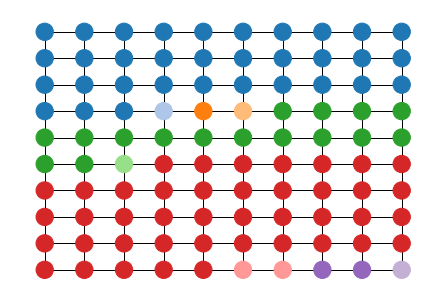

In [69]:
districts = [state.nodes[node]['label'] for node in state.nodes()]
color_map = [plt.cm.tab20(i) for i in districts]
nx.draw(state, node_color=color_map, pos=pos)

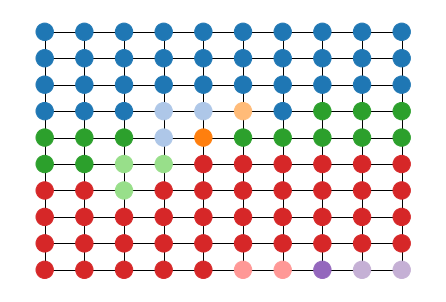

In [70]:
districts = [optimized.nodes[node]['label'] for node in optimized.nodes()]
color_map = [plt.cm.tab20(i) for i in districts]
nx.draw(optimized, node_color=color_map,pos=pos)

In [71]:
# The total party proportions in the state
print(proportions[1:3])

[0.46845396 0.53154604]


In [72]:
# The electoral party outcome in the standard graph
majority_outcomes(state, proportions)

array([0.5, 0.5])

In [73]:
# The electoral party outcome in the gerrymandered graph
majority_outcomes(optimized, proportions)

array([0.2, 0.8])

<h3>Generating/Loading data<h3>
(these functions take a very long time to run)

In [121]:
loader = data_loader(make_fairish_state, gerry_func)

In [125]:
loader.load(100,20)

In [144]:
state_tensor = torch.tensor(loader.proportions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [127]:
with torch.no_grad():
    label_tensor = torch.tensor(loader.labels)
    label_tensor = label_tensor.reshape(-1,1).float()

In [191]:
# Returns a tensor with the ratio between the statewide proportions and electoral outcomes for each data point
def proportion_tensor(loader):
    proportion_data = []
    for i, d in enumerate(torch.tensor(list(zip(loader.outcomes, loader.proportions)))):
        proportion_data.append(torch.cat((d[0], d[1])))
    for i, d_ in enumerate(proportion_data):
        proportion_data[i] = torch.div(torch.div(d_[0], d_[1]), torch.div(d_[2],  d_[3]))
    with torch.no_grad():
        proportion_tensor = torch.stack(proportion_data).reshape(-1,1).float().cuda()
    proportion_tensor.requires_grad=True
    return proportion_tensor

In [163]:
# Returns the learned featurwise representation of each graph
def featurewise_tensor(loader):
    featurewise_tensor_ = loader.featurewise_representations().cuda()
    featurewise_tensor_.requires_grad=True
    return torch.cat((state_tensor.cuda(), featurewise_tensor_), 1)

In [176]:
# Returns the learned featurewise representation of the party data for each graph
def partywise_tensor(loader):
    partywise_tensor_ = loader.featurewise_representations(party_limited=True).cuda()
    partywise_tensor_.requires_grad=True
    return torch.cat((state_tensor.cuda(), partywise_tensor_), 1)

In [165]:
label_tensor.requires_grad=True

In [192]:
proportion_tensor_ = proportion_tensor(loader)

In [174]:
featurewise_tensor_ = featurewise_tensor(loader)

In [187]:
partywise_tensor_ = partywise_tensor(loader)

<h3>Testing different classifiers<h3>

In [237]:
one_dimensional_classifier = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)

In [238]:
feature_hypothesis_classifier = torch.nn.Sequential(
    torch.nn.Linear(8,16),
    torch.nn.Tanh(),
    torch.nn.Linear(16,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8,4),
    torch.nn.Tanh(),
    torch.nn.Linear(4,1),
    torch.nn.Tanh()
)

In [239]:
party_hypothesis_classifier = torch.nn.Sequential(
    torch.nn.Linear(4,16),
    torch.nn.Tanh(),
    torch.nn.Linear(16,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8,4),
    torch.nn.Tanh(),
    torch.nn.Linear(4,1),
    torch.nn.Tanh()
)

In [240]:
def test_classifier(classifier, data_tensor, label_tensor):
    error_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(classifier.cuda().parameters(), .003)
    loss_values = []
    for step in range(5500):
        optimizer.zero_grad()
        predictions = classifier.cuda()(data_tensor).float()
        error = error_function(predictions,label_tensor).float()
        print(error)
        loss_values.append(error.cpu().detach())
        error.backward()
        optimizer.step()
    return loss_values

In [241]:
one_d_vals = test_classifier(one_dimensional_classifier.cuda(), proportion_tensor_.cuda(), label_tensor.cuda())

Streaming output truncated to the last 5000 lines.
tensor(0.0953, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0952, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0952, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0952, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0950, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0950, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0950, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0949, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0949, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0949, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0948, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0948, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0948, device='cuda:0', grad_fn=<MseLossB

In [242]:
# might be overfitting?
feature_vals = test_classifier(feature_hypothesis_classifier.cuda(), featurewise_tensor.cuda().float(), label_tensor.cuda().float())

Streaming output truncated to the last 5000 lines.
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1208, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1208, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1208, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1208, device='cuda:0', grad_fn=<MseLossB

In [243]:
party_vals = test_classifier(party_hypothesis_classifier.cuda(), partywise_tensor_.cuda().float(), label_tensor.cuda().float())

Streaming output truncated to the last 5000 lines.
tensor(0.1344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MseLossB

In [244]:
x = [i for i in range(5500)]

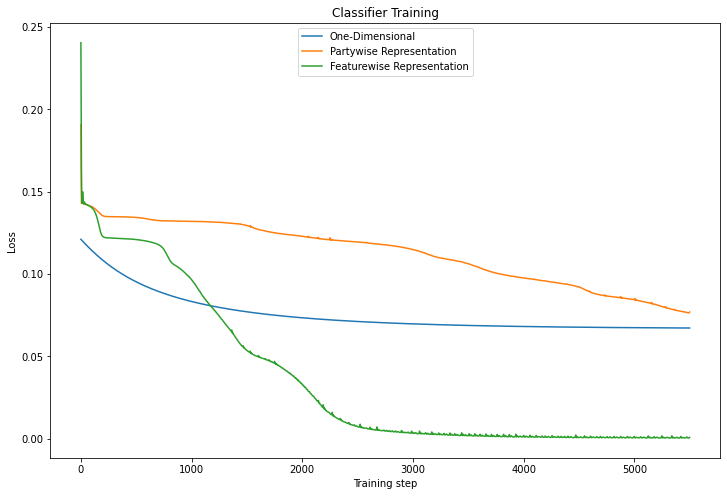

In [254]:
plt.figure(figsize=(12, 8))
plt.plot(x, one_d_vals, label='One-Dimensional')
plt.plot(x, party_vals, label='Partywise Representation')
plt.plot(x, feature_vals, label='Featurewise Representation')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Classifier Training')
plt.legend(loc='upper center')
plt.show()